In [11]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
from unidecode import unidecode
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

def normalize_column_name(col):
    col = re.sub('(\n|\t)', '', col) # replace \n and \t with ''
    col = col.lower() # lower
    col = re.sub(' ', '_', col) # repace ' ' with '_'
    col = unidecode(col) # remove accent
    return col

def del_column(df, col_list):
    rem = [i for i in df.columns if i not in col_list]
    df = df[rem]
    return df

# 1. Cleaning data

In [2]:
l = pd.read_html('https://en.wikipedia.org/wiki/List_of_English_football_champions')
df = l[1]
df.columns = [i[0] for i in df.columns]
df = (df[~  ((df['Ed.'].str.contains('\(')) | (df['Champions (number of titles)'].str.contains('War')))])
df.columns = [normalize_column_name(i) for i in df.columns]
df = df.rename({'champions_(number_of_titles)': 'champion'}, axis = 1)
df = df.loc[:,['season', 'champion', 'runners-up', 'third_place', 'winning_manager']]
df.champion = df.champion.str.extract('(^[\w\s]+)')
df.champion = df.champion.str.strip()

df = (
    df
    .assign(season_start = lambda df_: df_.season.apply(lambda x: int(x[:4])))
    .assign(season_end = lambda df_: df_.season_start + 1)
    .sort_values(by = ['champion', 'season_end'], ignore_index=True)
)

df['last_win'] = df.groupby('champion')['season_end'].shift(1)
df['next_win'] = df.groupby('champion')['season_end'].shift(-1)
df['gap'] = df['next_win'] - df['season_end']

df = df.replace('The Wednesday', 'Sheffield Wednesday')
df

<>:4: SyntaxWarning: invalid escape sequence '\('
<>:8: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\('
<>:8: SyntaxWarning: invalid escape sequence '\w'
C:\Users\minhtl3\AppData\Local\Temp\ipykernel_2792\1243544878.py:4: SyntaxWarning: invalid escape sequence '\('
  df = (df[~  ((df['Ed.'].str.contains('\(')) | (df['Champions (number of titles)'].str.contains('War')))])
C:\Users\minhtl3\AppData\Local\Temp\ipykernel_2792\1243544878.py:8: SyntaxWarning: invalid escape sequence '\w'
  df.champion = df.champion.str.extract('(^[\w\s]+)')


,season,champion,runners-up,third_place,winning_manager,season_start,season_end,last_win,next_win,gap
0,1930–31,Arsenal,Aston Villa,Sheffield Wednesday,Herbert Chapman,1930,1931,NaN,1933.0,2.0
1,1932–33,Arsenal,Aston Villa,Sheffield Wednesday,Herbert Chapman,1932,1933,1931.0,1934.0,1.0
2,1933–34,Arsenal,Huddersfield Town,Tottenham Hotspur,Joe Shaw (caretaker),1933,1934,1933.0,1935.0,1.0
3,1934–35,Arsenal,Sunderland,Sheffield Wednesday,George Allison,1934,1935,1934.0,1938.0,3.0
4,1937–38,Arsenal,Wolverhampton Wanderers,Preston North End,George Allison,1937,1938,1935.0,1948.0,10.0
...,...,...,...,...,...,...,...,...,...,...
120,1960–61,Tottenham Hotspur,Sheffield Wednesday,Wolverhampton Wanderers,Bill Nicholson,1960,1961,1951.0,NaN,NaN
121,1919–20,West Bromwich Albion,Burnley,Chelsea,Fred Everiss,1919,1920,NaN,NaN,NaN
122,1953–54,Wolverhampton Wanderers,West Bromwich Albion,Huddersfield Town,Stan Cullis,1953,1954,NaN,1958.0,4.0
123,1957–58,Wolverhampton Wanderers,Preston North End,Tottenham Hotspur,Stan Cullis,1957,1958,1954.0,1959.0,1.0


In [3]:
df = del_column(df, ['lientiep_label'])

In [4]:
def label_consecutive(manu):
    manu = manu.sort_values('season_end').reset_index(drop=True)
    manu['lientiep_group'] = (manu.season_end.diff() != 1).cumsum()

    manu['lientiep_label'] = (
        manu.lientiep_group
        .map(manu.groupby('lientiep_group')
        .season_end.count()).apply(lambda x: str(x) + ' consecutive titles' if x > 1 else '')
    )
    
    return manu.drop(columns= ['lientiep_group'])

df.groupby('champion', group_keys=False).apply(label_consecutive)

C:\Users\minhtl3\AppData\Local\Temp\ipykernel_2792\2397100529.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('champion', group_keys=False).apply(label_consecutive)


,season,champion,runners-up,third_place,winning_manager,season_start,season_end,last_win,next_win,gap,lientiep_label
0,1930–31,Arsenal,Aston Villa,Sheffield Wednesday,Herbert Chapman,1930,1931,NaN,1933.0,2.0,
1,1932–33,Arsenal,Aston Villa,Sheffield Wednesday,Herbert Chapman,1932,1933,1931.0,1934.0,1.0,3 consecutive titles
2,1933–34,Arsenal,Huddersfield Town,Tottenham Hotspur,Joe Shaw (caretaker),1933,1934,1933.0,1935.0,1.0,3 consecutive titles
3,1934–35,Arsenal,Sunderland,Sheffield Wednesday,George Allison,1934,1935,1934.0,1938.0,3.0,3 consecutive titles
4,1937–38,Arsenal,Wolverhampton Wanderers,Preston North End,George Allison,1937,1938,1935.0,1948.0,10.0,
...,...,...,...,...,...,...,...,...,...,...,...
1,1960–61,Tottenham Hotspur,Sheffield Wednesday,Wolverhampton Wanderers,Bill Nicholson,1960,1961,1951.0,NaN,NaN,
0,1919–20,West Bromwich Albion,Burnley,Chelsea,Fred Everiss,1919,1920,NaN,NaN,NaN,
0,1953–54,Wolverhampton Wanderers,West Bromwich Albion,Huddersfield Town,Stan Cullis,1953,1954,NaN,1958.0,4.0,
1,1957–58,Wolverhampton Wanderers,Preston North End,Tottenham Hotspur,Stan Cullis,1957,1958,1954.0,1959.0,1.0,2 consecutive titles


In [5]:
largest_gap = df[df.gap > 1].groupby('champion')['gap'].max()
df['largest_gap'] = df.apply(lambda row: "largest_gap" if row['gap'] == largest_gap.get(row['champion'], -1) else "", axis = 1)
largest_gap_df = df[df.largest_gap == 'largest_gap'].drop_duplicates(subset='champion', keep='last')

In [6]:
# largest_gap
laragest_gap = df[df.gap > 1].groupby('champion').gap.max()
df['largest_gap'] = df.apply(lambda df_: "largest_gap" if df_['gap'] == largest_gap.get(df_['champion'], -1) else "", axis=1)
df[df.largest_gap == 'largest_gap'].drop_duplicates(subset = 'champion', keep='last')

,season,champion,runners-up,third_place,winning_manager,season_start,season_end,last_win,next_win,gap,largest_gap
7,1970–71,Arsenal,Leeds United,Tottenham Hotspur,Bertie Mee,1970,1971,1953.0,1989.0,18.0,largest_gap
18,1909–10,Aston Villa,Liverpool,Blackburn Rovers,George Ramsay,1909,1910,1900.0,1981.0,71.0,largest_gap
21,1913–14,Blackburn Rovers,Aston Villa,Middlesbrough,Robert Middleton,1913,1914,1912.0,1995.0,81.0,largest_gap
23,1920–21,Burnley,Manchester City,Bolton Wanderers,John Haworth,1920,1921,NaN,1960.0,39.0,largest_gap
25,1954–55,Chelsea,Wolverhampton Wanderers,Portsmouth,Ted Drake,1954,1955,NaN,2005.0,50.0,largest_gap
31,1971–72,Derby County,Leeds United,Liverpool,Brian Clough,1971,1972,NaN,1975.0,3.0,largest_gap
37,1938–39,Everton,Wolverhampton Wanderers,Charlton Athletic,Theo Kelly (secretary manager),1938,1939,1932.0,1963.0,24.0,largest_gap
47,1973–74,Leeds United,Liverpool,Derby County,Don Revie,1973,1974,1969.0,1992.0,18.0,largest_gap
67,1989–90,Liverpool,Aston Villa,Tottenham Hotspur,Kenny Dalglish,1989,1990,1988.0,2020.0,30.0,largest_gap
70,1967–68,Manchester City,Manchester United,Liverpool,Joe Mercer,1967,1968,1937.0,2012.0,44.0,largest_gap


# 2. Analysis

### **Who were the winners?**

In [7]:
df.champion.nunique()

24

### **Who got the most titles?**

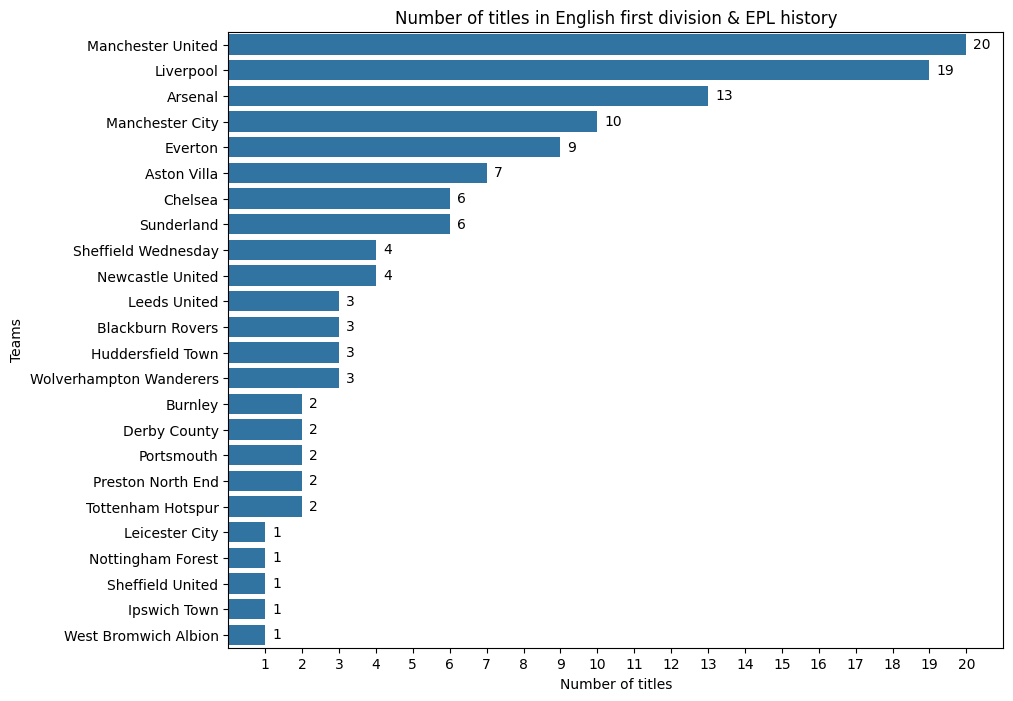

In [8]:
fig, ax = plt.subplots(figsize = (10,8))

champion_value_count = df.champion.value_counts()
num_champion = len(champion_value_count)

barplot = sns.barplot(
    champion_value_count
    ,orient= 'h'
    ,ax=ax
)

ax.set_title('Number of titles in English first division & EPL history')
ax.set_ylabel('Teams')
ax.set_xlabel('Number of titles')
plt.xticks(range(1,champion_value_count.max()+1))

for bar in barplot.containers:
    ax.bar_label(bar, padding = 5, label_type= "edge")
    ax.bar

plt.show()


In [9]:
epl_team = ['Manchester United', 'Liverpool', 'Arsenal', 'Manchester City', 'Everton', 'Aston Villa', 'Chelsea', 'Newcastle United', 'Wolverhampton Wanderers', 'Tottenham Hotspur', 'Leicester City', 'Nottingham Forest', 'Ipswich Town']
championship_team = ['Sunderland', 'Leeds United', 'Blackburn Rovers', 'Burnley', 'Derby County', 'Portsmouth', 'Preston North End', 'Sheffield United', 'West Bromwich Albion', 'Sheffield Wednesday']
league_one_team = ['Huddersfield Town']

competition_dict = {}
for i in [epl_team, championship_team, league_one_team]:
    for j in i:
        if i == epl_team:
            competition_dict[j] = 'EPL'
        elif i == championship_team:
            competition_dict[j] = 'Championship'
        elif i == league_one_team:
            competition_dict[j] = 'League One'
            
competition_dict

{'Manchester United': 'EPL',
 'Liverpool': 'EPL',
 'Arsenal': 'EPL',
 'Manchester City': 'EPL',
 'Everton': 'EPL',
 'Aston Villa': 'EPL',
 'Chelsea': 'EPL',
 'Newcastle United': 'EPL',
 'Wolverhampton Wanderers': 'EPL',
 'Tottenham Hotspur': 'EPL',
 'Leicester City': 'EPL',
 'Nottingham Forest': 'EPL',
 'Ipswich Town': 'EPL',
 'Sunderland': 'Championship',
 'Leeds United': 'Championship',
 'Blackburn Rovers': 'Championship',
 'Burnley': 'Championship',
 'Derby County': 'Championship',
 'Portsmouth': 'Championship',
 'Preston North End': 'Championship',
 'Sheffield United': 'Championship',
 'West Bromwich Albion': 'Championship',
 'Sheffield Wednesday': 'Championship',
 'Huddersfield Town': 'League One'}

### **When did they get the titles?**

AttributeError: 'DataFrame' object has no attribute 'lientiep_label'

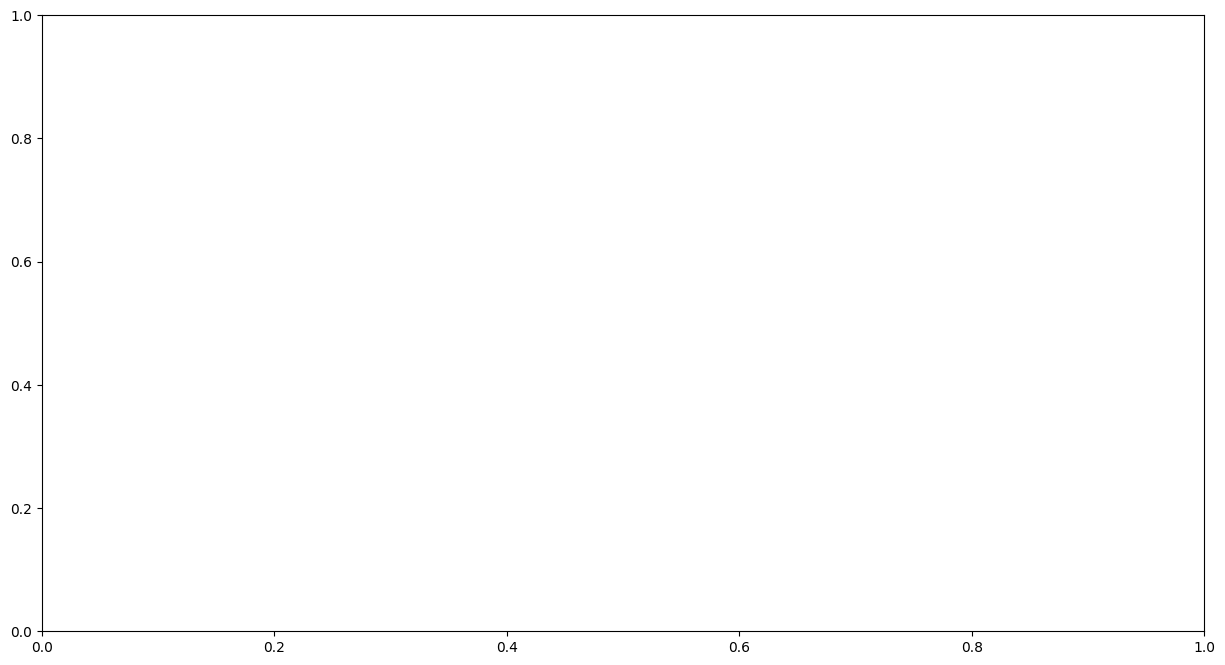

In [10]:
fig, ax = plt.subplots(figsize = (15,8))
min_x = 1880
max_x = 2030

lientiep_color_dict = {
    '4 consecutive titles': '#A4303F'
    ,'3 consecutive titles': '#379634'
    ,'2 consecutive titles': '#F5B841'
    ,'': '#84BCDA'
}

df['lientiep_color'] = df.lientiep_label.map(lientiep_color_dict)

sns.stripplot(
    data = df
    ,x = 'season_end'
    ,y = 'champion'
    ,jitter=False
    ,order= champion_value_count.index
    ,ax=ax
    ,hue= 'lientiep_label'
    ,palette= lientiep_color_dict
)

for i, (index, row) in enumerate(largest_gap_df.iterrows()):
    plt.plot([row['season_end'], row['next_win']], [row['champion'], row['champion']], color = 'grey')
    plt.text(
        x = (row['season_end'] + row['next_win'])/2
        , y = row['champion'], s = str(int(row['gap'])) + ' years'
        , fontsize = 9
        , ha = 'center'
        , va = 'bottom'
        , style = 'italic'
    )

ax.legend(title = 'Num of consecutive titles')
ax.set_title('History of English First Division & EPL Winners', fontweight = 'bold', fontsize = 14, y = 1.03)
ax.text(0.5, 1, "and the longest periods between two titles",
        ha="center", va="bottom", transform=ax.transAxes, fontsize=12, color="gray")
# ax.sup
ax.set_xlabel('Years')
ax.set_ylabel('Teams')
ax.set_xlim((min_x, max_x))
ax.set_xticks(range(min_x, max_x, 10))

plt.grid(axis="y", color="grey", linestyle="--", alpha=0.7)
plt.grid(axis="x", color="grey", linestyle="--", alpha=0.7)

for i, val in enumerate(champion_value_count):
    plt.text(x = min_x+1, y = champion_value_count.index[i], s = str(val), va = 'center')


plt.show()